In [31]:
%load_ext autoreload
%autoreload 2

# System imports
from dataclasses import dataclass
from typing import NamedTuple, Callable, Optional
import time

import haiku as hk
import jax
import jax.numpy as jnp
import jraph
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_median, Predictive
from numpyro.diagnostics import hpdi
import optax

# Local imports
import loss
import dataset
from model import VGAE, VGAEOutput, decoder, PriorVAE
import plotting

print(f"JAX version: {jax.__version__}")
print(f"Numpyro version: {numpyro.__version__}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
JAX version: 0.3.13
Numpyro version: 0.9.2


In [32]:
RNG_KEY = jax.random.PRNGKey(42)

In [33]:
IMAGE_SHAPE = (15, 10)

(
    A, D, d, 
    num_regions, 
    (num_x, num_y),
) = dataset.generate_synthetic_dataset(IMAGE_SHAPE[0], IMAGE_SHAPE[1])

np.linalg.det(np.linalg.inv(D - A))

0.0

In [34]:
from typing import Dict

Params = Dict[str, Dict[str, jnp.ndarray]]

@dataclass
class CARArgs:
  adj_matrix: np.ndarray = A
  degree_vector: jnp.ndarray = d
  decoder_params: Optional[Params] = None
  
CAR_ARGS = CARArgs()

In [35]:
def car_predictive_model(args: CARArgs) -> None:
  A = jnp.array(args.adj_matrix)
  D = jnp.diag(args.degree_vector)

  # alpha = numpyro.sample('alpha', dist.Uniform(low=0.4, high=0.999))
  alpha = 0.7

  Q = (D - alpha*A)
  numpyro.sample('car', dist.MultivariateNormal(loc=jnp.zeros(num_regions), precision_matrix=Q))

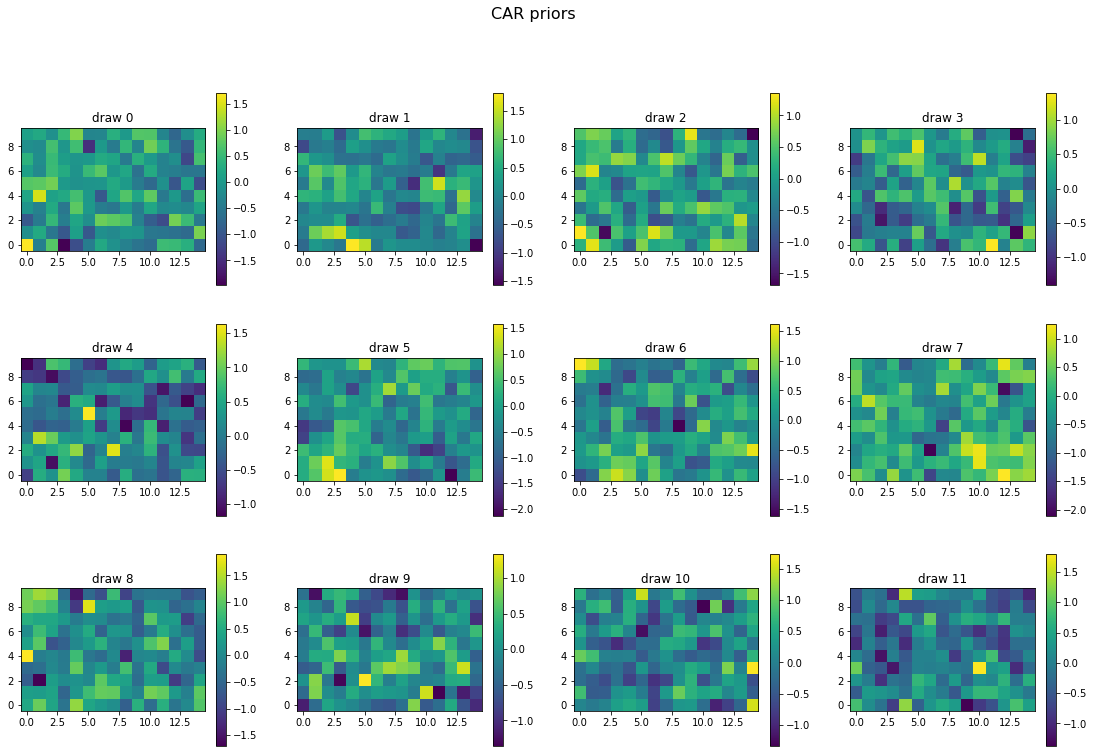

In [36]:
# CAR: prior predictive
RNG_KEY, rng_pred = jax.random.split(RNG_KEY)

car_preds = Predictive(car_predictive_model, num_samples=1000)(rng_pred, CAR_ARGS)
car_draws = car_preds['car']

plotting.plot_samples(car_draws, image_shape=IMAGE_SHAPE)

In [37]:
def generate_car_batch(
        rng: jax.random.PRNGKey, 
        batch_size: int = 32,
        model_args: CARArgs = CAR_ARGS) -> jraph.GraphsTuple:
    car_preds = Predictive(
        car_predictive_model, num_samples=batch_size)(rng, model_args)
    car_draws = car_preds['car']  # (batch_size, num_regions)
    return car_draws

# Training VAE

In [38]:
LossFun = Callable[[jax.numpy.ndarray, jax.numpy.ndarray], jnp.float32]

class Args(NamedTuple):
  loss_fn: LossFun = loss.compute_mse_loss
  
  batch_size: int = 100  # saw 100 is better than 500.
  
  hidden_dim: int = 130
  latent_dim: int = 130
  output_dim: int = A.shape[0]
  
  learning_rate: float = 1e-3
  epochs: int = 7000  # 5000 showed promising results.
  
  eval_frequency: int = 100
  
ARGS = Args()
print(ARGS)

Args(loss_fn=<function compute_mse_loss at 0x13b862d30>, batch_size=100, hidden_dim=130, latent_dim=130, output_dim=150, learning_rate=0.001, epochs=7000, eval_frequency=100)


## PriorVAE model

In [39]:
from typing import Tuple

ACT_FN = jax.nn.elu

def priorvae_encoder(
        x: jnp.ndarray,
        hidden_dim: int,
        latent_dim: int) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """Encoder for PriorVAE."""
    x = hk.Flatten()(x)
    x = hk.Sequential(
        [
            hk.Linear(hidden_dim),
            ACT_FN,
        ]
    )(x)
    mean = hk.Linear(latent_dim, name='mean')(x)
    log_std = hk.Linear(latent_dim, name='log_std')(x)
    return mean, log_std


def priorvae_decoder(
        z: jnp.ndarray,
        hidden_dim: int,
        output_dim: int) -> jraph.GraphsTuple:
    output = hk.Sequential(
        [
            hk.Linear(hidden_dim, name='decoder_hidden'),
            ACT_FN,
            hk.Linear(output_dim, name='output'),
        ]
    )(z)
    output = jnp.reshape(output, (-1, output_dim))
    return output


class PriorVAE(hk.Module):
    """Main VAE model class, uses Encoder & Decoder under the hood."""

    def __init__(
        self,
        hidden_dim: int,
        latent_dim: int,
        output_dim: int,
    ):
        super().__init__()
        self._hidden_dim = hidden_dim
        self._latent_dim = latent_dim
        self._output_dim = output_dim

    def __call__(self, x: jnp.ndarray) -> VGAEOutput:
        x = x.astype(jnp.float32)
        mean, log_std = priorvae_encoder(
            x,
            self._hidden_dim,
            self._latent_dim,
        )

        std = jnp.exp(log_std)
        z = mean + std * jax.random.normal(hk.next_rng_key(), mean.shape)

        output = priorvae_decoder(
            z,
            self._hidden_dim,
            self._output_dim,
        )

        return VGAEOutput(mean, std, output)

In [40]:
net = hk.transform(
  lambda x: PriorVAE(
    hidden_dim=ARGS.hidden_dim,
    latent_dim=ARGS.latent_dim, 
    output_dim=ARGS.output_dim)(x))

In [41]:
optimizer = optax.adam(learning_rate=ARGS.learning_rate)

In [42]:
@jax.jit
def loss_fn(
    params: hk.Params, 
    rng_key: jnp.ndarray,
    batch: jnp.ndarray,
) -> jnp.ndarray:
  """Computes VGAE loss."""
  log_likelihood_loss_fn = ARGS.loss_fn
  
  outputs: VGAEOutput = net.apply(params, rng_key, batch)
  
  log_likelihood = -log_likelihood_loss_fn(outputs.output, batch)
  kld = jnp.mean(loss.compute_kl_gaussian(outputs.mean, outputs.log_std), axis=-1)
  elbo = log_likelihood - kld
  
  return -elbo
  
@jax.jit
def update(
    params: hk.Params,
    rng_key: jnp.ndarray,
    opt_state: optax.OptState,
    batch: jnp.ndarray,
):
  """Updates the parameters of the network."""
  grads = jax.grad(loss_fn)(params, rng_key, batch)
  updates, new_opt_state = optimizer.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, new_opt_state

In [43]:
# Initialize net with an arbitrary graph
RNG_KEY, rng_init, rng_params = jax.random.split(RNG_KEY, 3)

init_batch = generate_car_batch(rng_init, batch_size=ARGS.batch_size)
params = net.init(rng_params, init_batch)
opt_state = optimizer.init(params)

In [44]:
RNG_KEY, train_rng = jax.random.split(RNG_KEY)

train_losses = []
val_losses = []

training_start_time = time.time()
print('using: ', ARGS.loss_fn)
for epoch in range(ARGS.epochs):   
  update_rng, train_data_rng = jax.random.split(jax.random.fold_in(train_rng, epoch))
  
  train_batch = generate_car_batch(train_data_rng, batch_size=ARGS.batch_size)
  params, opt_state = update(params, update_rng, opt_state, train_batch)
  
  if epoch % ARGS.eval_frequency == 0 or epoch == (ARGS.epochs - 1):
    evaluate_rng = jax.random.fold_in(update_rng, epoch)
    train_loss_rng, eval_loss_rng, val_data_rng = jax.random.split(evaluate_rng, 3)
    
    train_loss = loss_fn(params, train_loss_rng, train_batch)
    
    val_batch = generate_car_batch(val_data_rng, batch_size=ARGS.batch_size)
    val_loss = loss_fn(params, eval_loss_rng, val_batch)
    
    print(f'{time.strftime("%H:%M:%S", time.localtime())} STEP: {epoch}; '
                f'Train loss: {train_loss:.3f}; Validation loss: {val_loss:.3f}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)

training_end_time = time.time() - training_start_time
print(f'Training took: ({training_end_time:.3f} secs; equivalently {training_end_time/60:.3f} mins)')

using:  <function compute_mse_loss at 0x13b862d30>
15:17:51 STEP: 0; Train loss: 767.547; Validation loss: 793.622
15:18:33 STEP: 100; Train loss: 272.688; Validation loss: 260.384
15:19:18 STEP: 200; Train loss: 145.972; Validation loss: 139.086
15:20:04 STEP: 300; Train loss: 77.507; Validation loss: 76.767
15:20:40 STEP: 400; Train loss: 45.189; Validation loss: 42.409
15:21:13 STEP: 500; Train loss: 27.625; Validation loss: 26.803
15:21:46 STEP: 600; Train loss: 18.957; Validation loss: 19.141
15:22:19 STEP: 700; Train loss: 13.475; Validation loss: 13.646
15:22:52 STEP: 800; Train loss: 10.166; Validation loss: 10.289
15:23:25 STEP: 900; Train loss: 8.596; Validation loss: 8.244
15:24:01 STEP: 1000; Train loss: 6.593; Validation loss: 6.315
15:24:32 STEP: 1100; Train loss: 5.578; Validation loss: 5.440
15:25:05 STEP: 1200; Train loss: 4.658; Validation loss: 4.369
15:25:42 STEP: 1300; Train loss: 3.846; Validation loss: 3.910
15:26:14 STEP: 1400; Train loss: 3.254; Validation loss

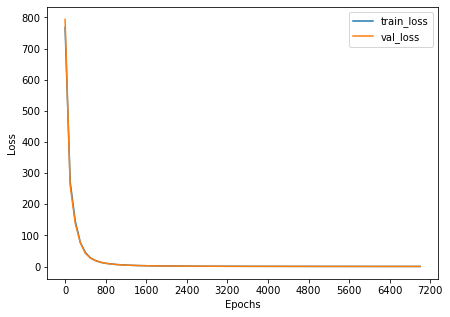

In [45]:
from matplotlib.ticker import MaxNLocator

ax = plt.figure(figsize=(7, 5)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
xs = np.arange(len(train_losses))*ARGS.eval_frequency
plt.plot(xs, train_losses, label='train_loss')
plt.plot(xs, val_losses, label='val_loss')

ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
plt.legend()
plt.show()

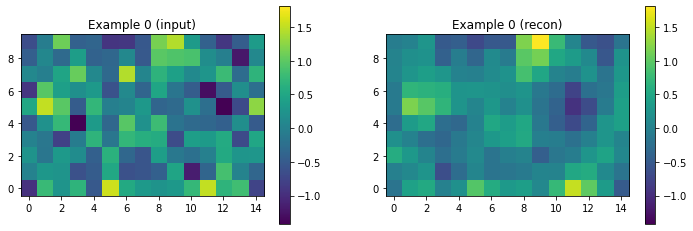

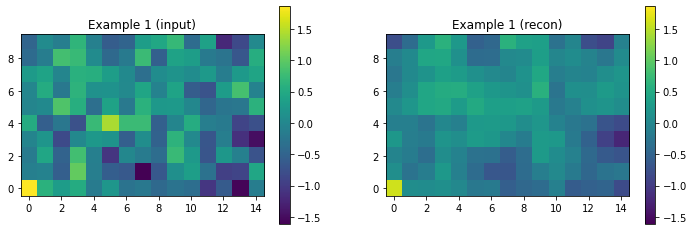

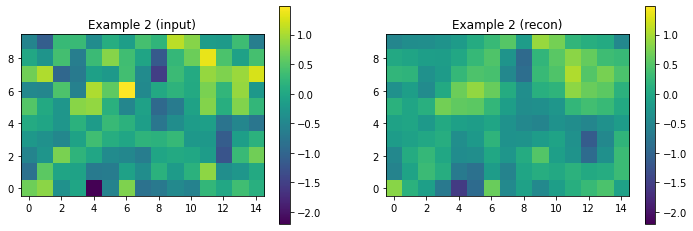

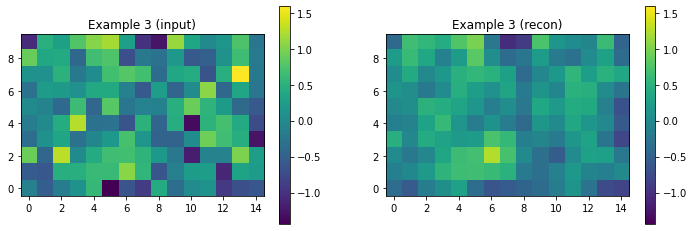

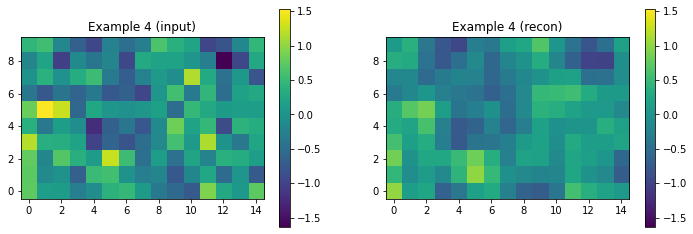

In [46]:
RNG_KEY, rng_recon = jax.random.split(RNG_KEY)

for i in range(5):
    data_rng = jax.random.fold_in(rng_recon, i)
    data_batch = generate_car_batch(data_rng, batch_size=ARGS.batch_size)
    outputs = net.apply(params, RNG_KEY, data_batch)
    out = outputs.output

    example_image = jnp.ravel(data_batch[0])
    recon_image = jnp.ravel(out[0])

    ax = plotting.plot_images_from_arrays(
        arrays=[example_image, recon_image],
        titles=['input', 'recon'],
        image_shape=IMAGE_SHAPE,
        # custom_min=-0.1,
        # custom_max=0.1
    )
    
    ax[0].set_title(f'Example {i} (input)')
    ax[1].set_title(f'Example {i} (recon)')